#EDA for myanimelist dataset for recommendation engine
##-Data preprocessing
Let's first import our data from the drive and take a first look at it!

In [0]:
#mount driver with data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Update with latest packages

In [0]:
!pip install pandas==0.23.4

In [0]:
#read data
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import math

animes = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/aniRec/data/anime_filtered.csv")

In [0]:
#Look at first 10 rows
animes.head(10)

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."
5,6586,Yume-iro Pâtissière,NaN,夢色パティシエール,"Yumeiro Patissiere, YumePati, Dream-Colored Pa...",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,50,Finished Airing,False,"Oct 4, 2009 to Sep 26, 2010","{'from': '2009-10-04', 'to': '2010-09-26'}",24 min. per ep.,G - All Ages,8.03,21618,526.0,1630,45625,826,NaN,Fall 2009,Unknown,"{'Adaptation': [{'mal_id': 10386, 'type': 'man...","Yomiuri Telecasting, DAX Production, Shueisha",NaN,"Studio Pierrot, Studio Hibari","Kids, School, Shoujo","['""Yume ni Yell! Patissiere♪ (夢にエール！パティシエール♪)""...","['""Ichigo no Miracle (いちごのミラクルール)"" by Yukina S..."
6,178,Ultra Maniac,Ultramaniac - Magical Girl,ウルトラマニアック,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"May 20, 2003 to 

In [0]:
animes.describe(include='all')

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
count,14474.000000,14474,5723,14440,8936,14378,14474,14474,14474.000000,14474,14474,14474,14474,14474,14474,14474.000000,1.447400e+04,12901.000000,14474.000000,1.447400e+04,14474.000000,1057,4096,4271,14474,8288,3373,8544,14410,14474,14474
unique,NaN,14473,5605,13698,8574,14378,7,16,NaN,3,2,10026,9649,301,7,NaN,NaN,NaN,NaN,NaN,NaN,1038,221,441,9418,3221,193,778,4544,4328,5458
top,NaN,Hinamatsuri,Cyborg 009,ゲゲゲの鬼太郎,Minna no Uta,https://myanimelist.cdn-dena.com/images/anime/...,TV,Unknown,NaN,Finished Airing,False,Not available,"{'from': None, 'to': None}",24 min. per ep.,PG-13 - Teens 13 or older,NaN,NaN,NaN,NaN,NaN,NaN,Includes claymation short which was shown befo...,Spring 2017,Unknown,[],NHK,Funimation,Toei Animation,Hentai,[],[]
freq,NaN,2,4,6,189,1,4271,4210,NaN,13790,14123,222,1689,1513,5020,NaN,NaN,NaN,NaN,NaN,NaN,5,80,2241,4513,427,726,725,867,9780,8803
mean,17371.948183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.310971,NaN,NaN,NaN,NaN,NaN,NaN,6.144179,1.146319e+04,6439.625068,7220.277256,2.297275e+04,311.735595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13163.266015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.449161,NaN,NaN,NaN,NaN,NaN,NaN,1.460617,4.311072e+04,3719.462602,4168.959000,7.499075e+04,2615.910510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4387.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.550000,4.600000e+01,3218.000000,3613.250000,2.450000e+02,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15128.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.370000,5.010000e+02,6442.000000,7225.500000,1.682500e+03,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,31142.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.060000,3.947250e+03,9664.000000,10826.750000,1.038050e+04,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
print(animes.columns)

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme'],
      dtype='object')


### Animes data preprocessing

We have multiple features to parse through, let's go through each of them one by one.
1. anime_id: MAL website id for the anime
2. title: Title of the anime
3. title_english: english title
4. title_japanese: japanese title
5. title_synonyms: title synonyms
6. image_url: url for anime image
7. type: type of medium (e.g. TV show, Movie, OVA, ...)
8. source: source material of the anime (e.g. original, manga, light novel...)
9. episodes: # of episodes for the anime. (equals to 1 if movie)
10. status: anime's broadcasting status (e.g. currently airing, aired, not aired yet)
11. airing: true/false for airing status
12. aired_string: string value for when the anime was aired
13. aired: dictionary saving the dates when the anime was aired (e.g. {'from': ..... , 'to': ....})
14. duration: duration of each episode
15. rating: age rating for content (will be used to rule out adult content)
16. score: average score (1~10) for the anime
17. scored_by: number of people who scored the anime
18. rank: rank of the anime by score
19. popularity: popularity ranking for the anime
20. members: # of people who have either watched / watching / will watch this anime
21. favorites: # of people who indicated that they like this show
22. background: text summary for anime background
23. premiered: date when the anime was premiered
24. broadcast: days of the week it was broadcasted
25. related: anime_id for related materials (prequels, sequels, etc.)
26. producers: list of producers involved in production
27. licensor: licensor of the anime
28. studio: studio(s) who were involved in production of the anime
29. genre: list of geners for this anime
30. opening_theme: list of OP for the anime
31. ending_theme: list of ED for the anime

Quite a list! First, let us remove some redundant / irrelevant features to clean up our data

## Removing irrelevant / redundant features

1. the titles in different languages are irrelevant and also redudant for data analysis.
2. aired column already tells when the anime was aired so aired string is irrelevant
3. airing column is also redundant because status column already tells it's airing status
4. premiered is redundant because it doesn't add much information from aired column



In [0]:
animes = animes.drop(columns=['title_english','title_japanese','title_synonyms','aired_string','airing','premiered'])
print(animes.shape)
animes.head(10)

(14474, 25)


,anime_id,title,image_url,type,source,episodes,status,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,"{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,"{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,"{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,"{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,"{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,50,Finished Airing,"{'from': '2009-10-04', 'to': '2010-09-26'}",24 min. per ep.,G - All Ages,8.03,21618,526.0,1630,45625,826,NaN,Unknown,"{'Adaptation': [{'mal_id': 10386, 'type': 'man...","Yomiuri Telecasting, DAX Production, Shueisha",NaN,"Studio Pierrot, Studio Hibari","Kids, School, Shoujo","['""Yume ni Yell! Patissiere♪ (夢にエール！パティシエール♪)""...","['""Ichigo no Miracle (いちごのミラクルール)"" by Yukina S..."
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,"{'from': '2003-05-20', 'to': '2003-11-11'}",24 min. per ep.,G - All Ages,7.26,9663,2594.0,2490,22778,122,NaN,Tuesdays at 22:00 (JST),"{'Adaptation': [{'mal_id': 956, 'type': 'manga...","WAO World, Studio Jack","Discotek Media, Geneon Entertainment USA",Production Reed,"Magic, Comedy, Romance, School, Shoujo","['""Kagami no Naka"" by can/goo']","['""Hitotsu=Unmei Kyoudoutai"" by can/goo']"
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,24,Finished Airing,"{'from': '2007-10-05', 'to': '2008-03-28'}",24 min. per ep.,PG-13 - Teens 13 or older,7.72,126085,1066.0,332,220591,1075,NaN,Fridays at 01:25 (JST),"{'Adaptation': [{'mal_id': 3074, 'type': 'mang...","Geneon U

In [0]:
animes = animes[animes['rating']!='Rx - Hentai']
print(animes.shape)

(13256, 25)


## Processing date and time
Since dates in the dateset are given as string, let us convert them to datetime objects.
Let's process these two features:
1. aired
2. broadcast

In [0]:
from datetime import datetime, date
import ast

#process aired object
def process_date(date):
    if date is None:
        return np.nan
    else:
        return datetime.strptime(date,'%Y-%m-%d')
#make two new columns
animes['aired_from'] = animes['aired'].apply(lambda x: process_date(ast.literal_eval(x)['from']))
animes['aired_to'] = animes['aired'].apply(lambda x: process_date(ast.literal_eval(x)['to']))
#drop the original column
animes = animes.drop(columns=['aired'])
animes[['aired_from','aired_to']].head(10)

,aired_from,aired_to
0,2012-01-13,2012-03-30
1,2007-04-02,2007-10-01
2,2008-10-04,2009-09-25
3,2002-08-16,2003-05-23
4,2012-10-06,2013-03-30
5,2009-10-04,2010-09-26
6,2003-05-20,2003-11-11
7,2007-10-05,2008-03-28
8,2008-10-10,2008-12-19
9,2006-04-05,2006-09-27


In [0]:
#process broadcast
def process_day(day):
    #replace to nan if "Unknown"
    if day == 'Unknown' or type(day) is float:
        return np.nan
    else:
        return day.split(' ', 1)[0]
animes['broadcast'] = animes['broadcast'].apply(lambda x: process_day(x))
print(animes['broadcast'].head(10))

0       Fridays
1           NaN
2           NaN
3       Fridays
4           NaN
5           NaN
6      Tuesdays
7       Fridays
8       Fridays
9    Wednesdays
Name: broadcast, dtype: object


## Processing opening and ending theme

Ending themes and opening themes are strings that contain titles of the music in the anime and the muscisians involved. Since the titles itself is not relevant, but since users may have certain preferences to the musicians, let's extract the names.

In [0]:
import re
import ast
def process_music(music_arr):
    music_arr = ast.literal_eval(music_arr)
    processed_arr = set() #use set instead of list to avoid duplicates
    for i in range(len(music_arr)):
        search = re.search("by(.*)",music_arr[i],re.U) # extract everything after "by" (e.g. [song_name] by [musician_name])
        if(search is not None):
            #replace any seperators with comma
            element = search.group(1).replace(', and',',').replace('and',',').replace('&',',') \
                                     .replace('; produced by ',',').replace('; performed by ',',')
            #remove elements in brackets and split with comma
            element = re.sub("[\(\[].*?[\)\]]", "", element).split(',')
            #strip and add all musician strings to list
            for musician in element:
                processed_arr.add(musician.strip())
    return processed_arr
animes['opening_theme'] = animes['opening_theme'].apply(lambda x:process_music(x))
animes['ending_theme'] = animes['ending_theme'].apply(lambda x:process_music(x))
#find union between musicians for opening/ending theme
animes['musicians'] = animes.apply(lambda x: list(x['opening_theme'].union(x['ending_theme'])),axis=1)
#drop original columns
animes = animes.drop(columns=['opening_theme','ending_theme'])
print(animes['musicians'].head(10))

0    [MUCC, Karuta Roromiya, Zange Natsume, Kagerou...
1                            [SUN, LUNAR, Asuka Hinoi]
2               [Guardians 4, Shugo Chara Egg, Buono!]
3                                    [Ritsuko Okazaki]
4            [nano.RIPE, Sphere, Hyadain, JAM Project]
5                      [Yukina Sugihara, Mayumi Gojou]
6                                            [can/goo]
7                   [Mami Kawada, Kawada Mami, KOTOKO]
8            [The Gospellers, Emiri Miyamoto x Solita]
9                       [Last Alliance, Chieko Kawabe]
Name: musicians, dtype: object


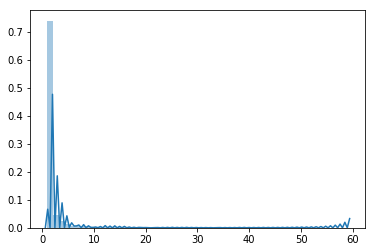

In [0]:
from collections import defaultdict
import seaborn as sns

def get_people_df(column):
  full_list = [] #list for every people in group
  for people in column:
    for person in people:
      full_list.append(person)
  #use integer dict to count # of people in list
  frequency_dict = defaultdict(int)
  for item in full_list:
    frequency_dict[item] += 1
  return pd.DataFrame(frequency_dict,index=['count']).T

musician_df = get_people_df(animes['musicians'])
sns.distplot(musician_df)

Seems like we have a normal distribution where most bands/musicians were involved in making only 1~2 songs for the shows. Since these very minor musicians are not very representative of the data, let's only consider musicians who have made more than 3 opening/ending themes

In [0]:
musician_df = musician_df[musician_df['count']>3]

In [0]:
musician_df=musician_df.drop(['#039;s','#039;n','','#039;S','#039;','???','y']) #drop mal-formatted strings
print(musician_df.shape)

(690, 1)


In [0]:
#remove musicians who were not in the removal list
def remove_minor(musicians,removal_list):
  for musician in musicians:
    if musician not in removal_list:
      musicians = list(filter(lambda a: a != musician, musicians))
  return musicians
animes['musicians']=animes['musicians'].apply(lambda x: remove_minor(x,musician_df.index.tolist()))

## Episode length
Now, let's process episode length and extract numbers from it

In [0]:
def process_duration(episode_length):
  if episode_length == 'Unknown':
    return 0
  numbers_list = [int(s) for s in episode_length.split() if s.isdigit()]
  if('sec' in episode_length):
    return 0
  if(len(numbers_list)==1):
    return numbers_list[0]
  if(len(numbers_list)==2):
    return 60*numbers_list[0]+numbers_list[1]
animes['duration'] = animes['duration'].apply(lambda x: process_duration(x))

In [0]:
animes['duration']

0        24
1        24
2        24
3        16
4        24
5        24
6        24
7        24
8        23
9        23
10       24
11       24
12       24
13       24
14       24
15       24
16       22
17       23
18       24
19       24
20       24
21       25
22       24
23       22
24       23
25       22
26       24
27       24
28       24
29       24
         ..
14444    18
14445     5
14446    12
14447    14
14448    13
14449    15
14450    15
14451    22
14452    15
14453    15
14454     0
14455     3
14456     2
14457    12
14458     2
14459     0
14460     2
14461    20
14462     2
14463    87
14464    13
14465    51
14466    13
14467    17
14468    20
14469     8
14470    25
14471     0
14472    40
14473     3
Name: duration, Length: 13256, dtype: int64

## Processing related feature
The 'relate' feature on the dataset represents related material to the anime. Let us use this feature to extract lists of related source material (manga) and related animes (sequel/prequels/spin-offs). These lists maybe useful for calculating similarity functions later on.

In [0]:
def process_related(related_dict,related_type):
  related_list = []
  if(related_dict == []):
    return related_list
  for key,value in related_dict.items():
    for item in value:
      if item['type'] == related_type:
        related_list.append(item['mal_id'])
  return related_list
#create related_animes and related_manga column to store related material's id as a list
animes['related_animes'] = animes['related'].apply(lambda x: process_related(ast.literal_eval(x),'anime'))
animes['related_manga'] = animes['related'].apply(lambda x: process_related(ast.literal_eval(x),'manga'))
#drop original column
animes = animes.drop(columns=['related'])
print(animes['related_animes'].head(10))
print(animes['related_manga'].head(10))

0                     [13403]
1         [4163, 5199, 28385]
2                [2923, 7082]
3                      [3265]
4       [10030, 15711, 23361]
5                [8894, 9441]
6                       [179]
7    [355, 3956, 14957, 6572]
8    [1698, 5656, 6187, 8038]
9                          []
Name: related_animes, dtype: object
0    [17207]
1      [759]
2      [101]
3     [1581]
4     [9711]
5    [10386]
6      [956]
7     [3074]
8      [419]
9       [30]
Name: related_manga, dtype: object


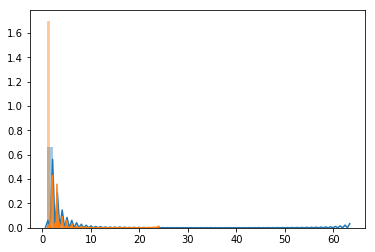

In [0]:
#reuse get_people_df function 
related_animes_df = get_people_df(animes['related_animes'])
related_manga_df = get_people_df(animes['related_manga'])
sns.distplot(related_animes_df)
sns.distplot(related_manga_df)

Looks like that the distribution follows a similar pattern. Most of the materials are not very influential. Also, animes seem to have much more related materials compared to mangas (green distribution is more to the left). Let's cut out very minor materials to filter out significant material in the market

In [0]:
related_animes_df = related_animes_df[related_animes_df['count']>5]
related_manga_df = related_manga_df[related_manga_df['count']>3]
print(related_animes_df.shape)
print(related_manga_df.shape)

(269, 1)
(132, 1)


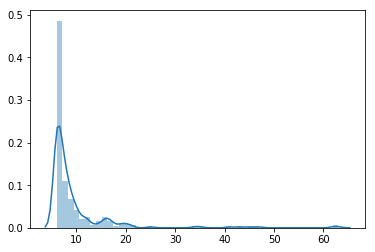

In [0]:
sns.distplot(related_animes_df)

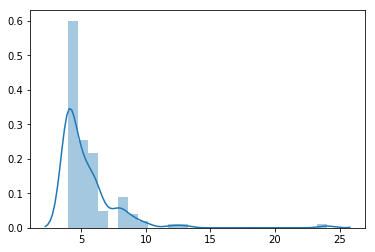

In [0]:
sns.distplot(related_manga_df)

In [0]:
#remove minor materials
animes['related_manga']=animes['related_manga'].apply(lambda x: remove_minor(x,related_manga_df.index.tolist()))
animes['related_animes']=animes['related_animes'].apply(lambda x: remove_minor(x,related_animes_df.index.tolist()))

##Producers, licensors, and studio

In the industry of anime, studios and producers have a great influence on art style, type of source materials, and quality. Licensors are not as influenctial but can affect anime's marketing to some degree. Let's first turn these features as a list and remove minor productions/licensors/studios.

In [0]:
def process_firms(firms):
  if(type(firms) is float):
    return []
  else:
    firms = firms.split(',')
    for i in range(len(firms)):
      firms[i] = firms[i].strip()
    return firms
animes['producer'] = animes['producer'].apply(lambda x: process_firms(x))
animes['licensor'] = animes['licensor'].apply(lambda x: process_firms(x))
animes['studio'] = animes['studio'].apply(lambda x: process_firms(x))

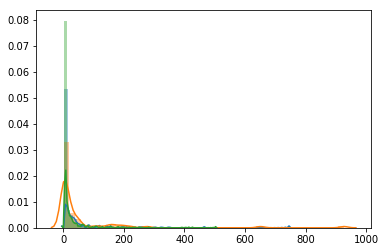

In [0]:
producer_df = get_people_df(animes['producer'])
licensor_df = get_people_df(animes['licensor'])
studio_df = get_people_df(animes['studio'])
sns.distplot(studio_df)
sns.distplot(licensor_df)
sns.distplot(producer_df)

(112, 1)
(19, 1)
(171, 1)


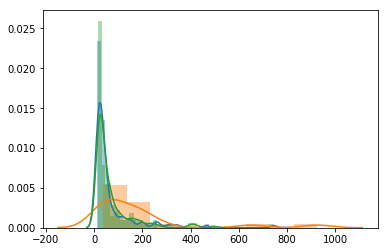

In [0]:
#we enforce a much higher cutoff for firms because we can see that the distributions are much more spread compared to other features
studio_df = studio_df[studio_df['count']>10] #cut-off of 10 was used to also include relatively new studios into consideration as well
licensor_df = licensor_df[licensor_df['count']>30]
producer_df = producer_df[producer_df['count']>15]
print(studio_df.shape)
print(licensor_df.shape)
print(producer_df.shape)
sns.distplot(studio_df)
sns.distplot(licensor_df)
sns.distplot(producer_df)

In [0]:
#remove minor data
animes['studio']=animes['studio'].apply(lambda x: remove_minor(x,studio_df.index.tolist()))
animes['licensor']=animes['licensor'].apply(lambda x: remove_minor(x,licensor_df.index.tolist()))
animes['producer']=animes['producer'].apply(lambda x: remove_minor(x,producer_df.index.tolist()))

##Additional data
The original Myanimelist data fro kaggle does not include some important features such as the staffs and characters in the anime as well as the description of the anime which can be used to reveal important features. Let's examine the data and merge it to the original one.

In [0]:
add_on = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/aniRec/data/anime_add_on.csv")
add_on.head(10)

,Unnamed: 0,anime_id,Staffs,Characters,Description
0,0,32561,"['Komatsu, Mikako', 'Hosoya, Yoshimasa', 'Shim...","['Yume', 'Haruhiro', 'Manato', 'Ranta']","Episode 2.5 of the series, will expand on the ..."
1,1,1778,[],"['Min, Jeong Ho', 'Seo, Jang Geum']",Story is about the girl Jang Geum who wants to...
2,2,37421,[],[],An animated commercial for the supermarket cha...
3,3,23855,"['Date, Hayato']",[],SD parody version of Voogie's Angel based on i...
4,4,35759,"['Nihei, Tsutomu']",[],Third season of Sidonia no Kishi.
5,5,37223,"['Sachi, Yun', 'Yokoyama, Hiromi']","['Ooki, Rinka', 'Ooki, Haruka', 'Ooki, Ryuuji']",NaN
6,6,1640,"['Yamaguchi, Kappei', 'Midorikawa, Hikaru', 'S...","['Hamura, Shou', 'Misonou, Kai', 'Ousaka, Chri...","In the Binfield Kingdom Chronicle, it is said ..."
7,7,10521,"['Fujita, Saki', 'Hirohashi, Ryou', 'Asumi, Ka...","['Inami, Mahiru', 'Yamada, Aoi', 'Taneshima, P...",The exciting antics of Wagnaria return as more...
8,8,35935,[],[],Official music video for Tamaki Roy's song Kot...
9,9,34859,[],[],An official music video for the song Tick Tock...


In [0]:
#merge the add_on data
animes = pd.merge(animes,add_on,on='anime_id')
animes.head(10)

,anime_id,title,image_url,type,source,episodes,status,duration,rating,score,scored_by,rank,popularity,members,favorites,background,broadcast,producer,licensor,studio,genre,aired_from,aired_to,musicians,related_animes,related_manga,Unnamed: 0,Staffs,Characters,Description
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,24,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Fridays,"[Aniplex, Square Enix, Mainichi Broadcasting S...",[Sentai Filmworks],[David Production],"Comedy, Supernatural, Romance, Shounen",2012-01-13,2012-03-30,[MUCC],[],[],4709,"['Nakamura, Yuuichi', 'Hidaka, Rina', 'Hanazaw...","['Miketsukami, Soushi', 'Shirakiin, Ririchiyo'...",Ririchiyo Shirakiin is the sheltered daughter ...
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,24,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,NaN,"[TV Tokyo, AIC, Square Enix, Sotsu]",[Funimation],[Gonzo],"Comedy, Parody, Romance, School, Shounen",2007-04-02,2007-10-01,[],[],[],7573,"['Momoi, Haruko', 'Mizushima, Takahiro', 'Noga...","['Seto, Sun', 'Michishio, Nagasumi', 'Edomae, ...",Michishio Nagasumi's life couldn't be any more...
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,24,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,NaN,"[TV Tokyo, Sotsu]",[],[Satelight],"Comedy, Magic, School, Shoujo",2008-10-04,2009-09-25,[],[],[],10353,"['Sawashiro, Miyuki', 'Itou, Kanae', 'Chiba, S...","['Tsukiyomi, Ikuto', 'Hinamori, Amu', 'Fujisak...",Now Utau has left Easter and restarted her sin...
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,16,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Fridays,"[Memory-Tech, GANSIS, Marvelous AQL]",[ADV Films],[Hal Film Maker],"Comedy, Drama, Magic, Romance, Fantasy",2002-08-16,2003-05-23,[Ritsuko Okazaki],[],[],652,"['Katou, Nanae', 'Sakurai, Takahiro', 'Mizuki,...","['Arima, Ahiru', 'Fakir', 'Kuroha, Rue', 'Myuu...","In a fairy tale come to life, the clumsy, swee..."
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,24,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,NaN,"[NHK, Shueisha]",[],[J.C.Staff],"Comedy, Drama, Romance, Shounen",2012-10-06,2013-03-30,"[nano.RIPE, Sphere, Hyadain, JAM Project]",[],[],4973,"['Abe, Atsushi', 'Hino, Satoshi', 'Okamoto, No...","['Mashiro, Moritaka', 'Takagi, Akito', 'Niizum...","Onto their third serialization, manga duo Mori..."
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,50,Finished Airing,24,G - All Ages,8.03,21618,526.0,1630,45625,826,NaN,NaN,"[Yomiuri Telecasting, DAX Production, Shueisha]",[],"[Studio Pierrot, Studio Hibari]","Kids, School, Shoujo",2009-10-04,2010-09-26,[Mayumi Gojou],[],[],11123,"['Okamoto, Nobuhiko', 'Yuuki, Aoi', 'Yonaga, T...","['Kashino, Makoto', 'Amano, Ichigo', 'Hanabusa...","Aside from her deep passion for eating cakes, ..."
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,24,G - All Ages,7.26,9663,2594.0,2490,22778,122,NaN,Tuesdays,[Studio Jack],"[Discotek Media, Geneon Entertainment USA]",[Production Reed],"Magic, Comedy, Romance, School, Shoujo",2003-05-20,2003-11-11,[can/goo],[],[],151,"['Kanda, Akemi', 'Horie, Yui', 'Chiba, Susumu'...","['Sakura, Nina', 'Tateishi, Ayu', 'Tsujiai, Hi...",Hideo Middle School eighth-grader Ayu Tateishi...
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,24,Finished Airing,24,PG-13 - Teens 13 or older,7.72,126085,1066.0,332,220591,1075,NaN,Fridays,"[Geneon Universal Entertainment, ASCII Media W...",[Funimation],[J.C.Staff],"Action, Drama, Fantasy, Romance, School, Super...",2007-10-05,2

In [0]:
print(animes.shape)
print(animes.columns)

(13256, 30)
Index(['anime_id', 'title', 'image_url', 'type', 'source', 'episodes',
       'status', 'duration', 'rating', 'score', 'scored_by', 'rank',
       'popularity', 'members', 'favorites', 'background', 'broadcast',
       'producer', 'licensor', 'studio', 'genre', 'aired_from', 'aired_to',
       'musicians', 'related_animes', 'related_manga', 'Unnamed: 0', 'Staffs',
       'Characters', 'Description'],
      dtype='object')


In [0]:
#drop irrelevant column from the add_on
animes = animes.drop(columns=['Unnamed: 0'])

In [0]:
#change them from string to list
animes['Staffs'] = animes['Staffs'].apply(lambda x: ast.literal_eval(x))
animes['Characters'] = animes['Characters'].apply(lambda x: ast.literal_eval(x))

##Characters and Staffs
Let's now process the characters and staffs using the similar process as other list-like features and filter minor characters and staffs

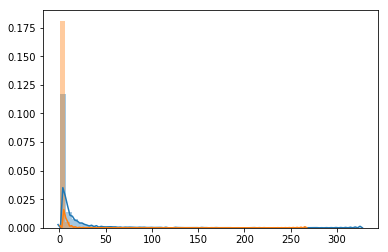

In [0]:
staff_df = get_people_df(animes['Staffs'])
character_df = get_people_df(animes['Characters'])
sns.distplot(staff_df)
sns.distplot(character_df)

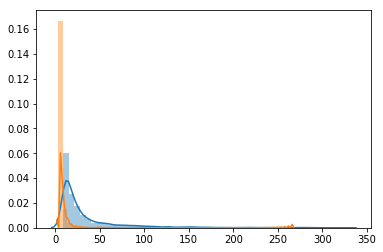

In [0]:
character_df = character_df[character_df['count']>=3] 
staff_df = staff_df[staff_df['count']>8]
sns.distplot(staff_df)
sns.distplot(character_df)

In [0]:
animes['Staffs']=animes['Staffs'].apply(lambda x: remove_minor(x,staff_df.index.tolist()))
animes['Characters']=animes['Characters'].apply(lambda x: remove_minor(x,character_df.index.tolist()))

##Description
Descriptions and synopsis for the anime contain important features which can be later processed with LDA or TF-IDF vectorizers for NLP. For now, let's only remove the citations for the sources of description.

In [0]:
def process_text(text):
  if(type(text) is float):
    return ""
  #remove citations inside brackets
  text = re.sub(r"\(Source(.*?)\)","",text)
  text = re.sub(r"\[Written(.*?)\]","",text)
  return text
animes['Description'] = animes['Description'].apply(lambda x: process_text(x))
animes['Description'].head(10)

0    Ririchiyo Shirakiin is the sheltered daughter ...
1    Michishio Nagasumi's life couldn't be any more...
2    Now Utau has left Easter and restarted her sin...
3    In a fairy tale come to life, the clumsy, swee...
4    Onto their third serialization, manga duo Mori...
5    Aside from her deep passion for eating cakes, ...
6    Hideo Middle School eighth-grader Ayu Tateishi...
7    The heated bond between Shana and Yuji is test...
8    Having been given the opportunity to study in ...
9    Haruhi Fujioka is a bright scholarship candida...
Name: Description, dtype: object

## Synthetic features
Lastly, adding synthetic features are crucial for data analysis. These can reveal more relevant information about the anime using real-life intuitions / knowledge about the data and the industry. Let's get to work!

In [0]:
#change genre to list format first
animes['genre'] = animes['genre'].apply(lambda x: [] if (type(x) is float) else x.split(','))

According myanimelists, the scores are already an weighted average and take into account how many people scored the anime, (otherwise, shows with just one 10 star rating would get placed on the list). scored_by feature is irrelevant since popularity and fame of the materials are already indicated by other features such as 'members' and 'favorites'

In [0]:
#drop scored_by
animes = animes.drop(columns=['scored_by'])

Knowing the percentage of people who have liked the anime out of people who have added the anime to the list may show the quality of the material

In [0]:
#make new favorites ratio feature
animes['favorites_ratio'] = animes['favorites']/animes['members']

From the broadcast_weekend feature, we can also indicate whether or not the anime was broadcasted on a weekend

In [0]:
animes['broadcast_weekend'] = animes['broadcast'].apply(lambda x: True if x=='Saturdays' or x=='Sundays' else False)

Next, let's examine time-related properties of the animes and extract some new features out of them. However, some of the data are missing becasue these animes are still on air or is not on air yet. We first need to impute these missing data for creating synthetic features

In [0]:
#fill Currently airing / Not yet aired materials with today's date
condition = np.logical_and(animes['status']=='Currently Airing',~animes['aired_from'].isna())
animes.loc[condition,'aired_to'] = date.today()
condition = np.logical_and(animes['status']=='Not yet aired',~animes['aired_from'].isna())
animes.loc[condition,'aired_to'] = date.today()

Now, let's bucketize the time periods based on how people classify different era's of anime based on its history. 1945 was during the world war II in Japan and 1973 was around the time when first animation production was found in Japan. During 1984, many people categorize this period as the first anime boom with Japan's bubble economy supporting it. Until in the 90's, Studio Ghbiri dominated the anime cinema markets. Then with the 90's and through the 2000's, anime gained major popularity. The rest of the time periods were divided based on influential works wuch as Monogatari Series and Suzumiya Haruhi no Yuutsu which changed the trend in anime industry. Note that these time buckets are purely subjective and based on popular classification of different eras in history of anime.

In [0]:
def bucketized_time_periods(time):
    time = time.year
    if(type(time) is float):
        return 'Unknown'
    if(time < 1945):
        return "ancient_times"
    elif(1945 <= time & time < 1973):
        return "toei_and_mushi_era"
    elif(1973 <= time & time < 1984):
        return "first_anime_boom"
    elif(1984 <= time & time < 1991):
        return "Ghibiri_era"
    elif(1991 <= time & time < 2000):
        return "the_90's"
    elif(2000 <= time & time < 2006):
        return "new_milenium"
    elif(2006 <= time & time < 2009):
        return "haruhism"
    elif(2009 <= time & time < 2012):
        return "monogatari"
    elif(2012 <= time & time < 2016):
        return "shinkai"
    else:
        return "new_age"
animes['time_bucket'] = animes['aired_from'].apply(lambda x: bucketized_time_periods(x))
animes['time_bucket'].head(10)

0         shinkai
1        haruhism
2        haruhism
3    new_milenium
4         shinkai
5      monogatari
6    new_milenium
7        haruhism
8        haruhism
9        haruhism
Name: time_bucket, dtype: object

In [0]:
#Calculate how many days this series was aired for
def length(x):
  from_date = x['aired_from']
  to_date = x['aired_to']
  if(type(from_date) is float):
    return np.nan
  duration = to_date - from_date
  return duration.days
animes['length'] = animes.apply(length,axis=1)
animes['length'].head(10)

0     77.0
1    182.0
2    356.0
3    280.0
4    175.0
5    357.0
6    175.0
7    175.0
8     70.0
9    175.0
Name: length, dtype: float64

Rankings of anime itself is good information, but dividing it into different buckets can help identity the algorithm which anime's are considered generally good or bad by the public opinion

In [0]:
def bucketized_rank(rank):
    if(rank == 0 or math.isnan(rank)):
        return 'Unknown'
    rank = int(rank)  
    if(1 <= rank & rank < 10):
        return "masterpiece"
    elif(10 <= rank & rank < 50):
        return "execellent"
    elif(50 <= rank & rank < 150):
        return "quality_show"
    elif(150 <= rank & rank < 300):
        return "fine_show"
    elif(300 <= rank & rank < 1000):
        return "normal_show"
    elif(1000 <= rank & rank < 4000):
        return "mediocre"
    else:
        return "below_average"
animes['rank_bucket'] = animes['rank'].apply(lambda x: bucketized_rank(x))
animes['rank_bucket'].head(10)

0        mediocre
1     normal_show
2        mediocre
3     normal_show
4    quality_show
5     normal_show
6        mediocre
7        mediocre
8       fine_show
9       fine_show
Name: rank_bucket, dtype: object

Now, let's also process duration into different categories as well. Normal TV shows are less than 45 minutes and shorter shows are less than 10 minutes and anything that's more than 60 minutes are usually movies

In [0]:
def bucketize_duration(duration):
  if(duration < 10):
    return 'short'
  elif(10 <= duration & duration < 45):
    return 'normal'
  elif(45 <= duration & duration < 60):
    return 'medium'
  else:
    return 'long'
animes['duration_bucket'] = animes['duration'].apply(lambda x: bucketize_duration(x))
animes['duration_bucket'].head(10)

0    normal
1    normal
2    normal
3    normal
4    normal
5    normal
6    normal
7    normal
8    normal
9    normal
Name: duration_bucket, dtype: object

##Images
Since Japanese animation is mostly a visual art which is drawn by people, it's aesthetics and art style can influence one's preference. Using url from each anime, the thumbnails for the images will be downloaded to the google drive for later processing. One idea is to use CNN to extract custom features from the thumbnail images.

In [0]:
#uncomment if you wish to run again
"""
from urllib.request import urlretrieve

for id,url in animes[['anime_id','image_url']].values:
  if(type(url) is not float):
    try:
      urlretrieve(url,'/content/gdrive/My Drive/Colab Notebooks/aniRec/data/images/'+str(id)+'.jpg')
    except:
      pass
"""

"\nfrom urllib.request import urlretrieve\n\nfor id,url in animes[['anime_id','image_url']].values:\n  if(type(url) is not float):\n    try:\n      urlretrieve(url,'/content/gdrive/My Drive/Colab Notebooks/aniRec/data/images/'+str(id)+'.jpg')\n    except:\n      pass\n"

In [0]:
animes

,anime_id,title,image_url,type,source,episodes,status,duration,rating,score,rank,popularity,members,favorites,background,broadcast,producer,licensor,studio,genre,aired_from,aired_to,musicians,related_animes,related_manga,Staffs,Characters,Description,favorites_ratio,broadcast_weekend,time_bucket,length,rank_bucket,duration_bucket
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,24,PG-13 - Teens 13 or older,7.63,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Fridays,"[Aniplex, Square Enix, Mainichi Broadcasting S...",[Sentai Filmworks],[David Production],"[Comedy, Supernatural, Romance, Shounen]",2012-01-13,2012-03-30,[MUCC],[],[],"[Nakamura, Yuuichi, Hidaka, Rina, Hanazawa, Ka...",[],Ririchiyo Shirakiin is the sheltered daughter ...,0.009895,False,shinkai,77.0,mediocre,normal
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,24,PG-13 - Teens 13 or older,7.89,727.0,366,204003,2579,NaN,NaN,"[TV Tokyo, AIC, Square Enix, Sotsu]",[Funimation],[Gonzo],"[Comedy, Parody, Romance, School, Shounen]",2007-04-02,2007-10-01,[],[],[],"[Momoi, Haruko, Mizushima, Takahiro, Nogawa, S...","[Seto, Sun, Michishio, Nagasumi, Edomae, Lunar...",Michishio Nagasumi's life couldn't be any more...,0.012642,False,haruhism,182.0,normal_show,normal
2,5262,Shugo Chara!! Doki,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,24,PG - Children,7.55,1508.0,1173,70127,802,NaN,NaN,"[TV Tokyo, Sotsu]",[],[Satelight],"[Comedy, Magic, School, Shoujo]",2008-10-04,2009-09-25,[],[],[],"[Sawashiro, Miyuki, Itou, Kanae, Chiba, Saeko,...","[Hinamori, Amu, Fujisaki, Nagihiko, Hotori, Ta...",Now Utau has left Easter and restarted her sin...,0.011436,False,haruhism,356.0,mediocre,normal
3,721,Princess Tutu,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,16,PG-13 - Teens 13 or older,8.21,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Fridays,"[Memory-Tech, GANSIS, Marvelous AQL]",[ADV Films],[Hal Film Maker],"[Comedy, Drama, Magic, Romance, Fantasy]",2002-08-16,2003-05-23,[Ritsuko Okazaki],[],[],"[Katou, Nanae, Sakurai, Takahiro, Mizuki, Nana...",[],"In a fairy tale come to life, the clumsy, swee...",0.035837,False,new_milenium,280.0,normal_show,normal
4,12365,Bakuman. 3rd Season,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,24,PG-13 - Teens 13 or older,8.67,50.0,426,182765,2082,NaN,NaN,"[NHK, Shueisha]",[],[J.C.Staff],"[Comedy, Drama, Romance, Shounen]",2012-10-06,2013-03-30,"[nano.RIPE, Sphere, Hyadain, JAM Project]",[],[],"[Abe, Atsushi, Hino, Satoshi, Okamoto, Nobuhik...","[Mashiro, Moritaka, Takagi, Akito, Niizuma, Ei...","Onto their third serialization, manga duo Mori...",0.011392,False,shinkai,175.0,quality_show,normal
5,6586,Yume-iro Pâtissière,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,50,Finished Airing,24,G - All Ages,8.03,526.0,1630,45625,826,NaN,NaN,"[Yomiuri Telecasting, DAX Production, Shueisha]",[],"[Studio Pierrot, Studio Hibari]","[Kids, School, Shoujo]",2009-10-04,2010-09-26,[Mayumi Gojou],[],[],"[Okamoto, Nobuhiko, Yuuki, Aoi, Yonaga, Tsubas...","[Kashino, Makoto, Amano, Ichigo, Hanabusa, Sat...","Aside from her deep passion for eating cakes, ...",0.018104,False,monogatari,357.0,normal_show,normal
6,178,Ultra Maniac,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,24,G - All Ages,7.26,2594.0,2490,22778,122,NaN,Tuesdays,[Studio Jack],"[Discotek Media, Geneon Entertainment USA]",[Production Reed],"[Magic, Comedy, Romance, School, Shoujo]",2003-05-20,2003-11-11,[can/goo],[],[],"[Kanda, Akemi, Horie, Yui, Chiba, Susumu, Kami...","[Rio, Luna]",Hideo Middle School eighth-grader Ayu Tateishi...,0.005356,False,new_milenium,175.0,mediocre,normal
7,2787,Shakugan no Shana II (Second),https://myanimelist.cdn-dena.com/images/anime/...,TV,Light novel,24,Finished Airing,24,PG-13 - Teen

##Missing data
The last stage of EDA is making sure that all the data are present. Some features were already processed and filled during feature engineering process but let's examine if we have anything else missing

In [0]:
animes.isna().sum()

anime_id                 0
title                    0
image_url               95
type                     0
source                   0
episodes                 0
status                   0
duration                 0
rating                   0
score                    0
rank                   357
popularity               0
members                  0
favorites                0
background           12213
broadcast            11226
producer                 0
licensor                 0
studio                   0
genre                    0
aired_from            1683
aired_to              1710
musicians                0
related_animes           0
related_manga            0
Staffs                   0
Characters               0
Description              0
favorites_ratio          4
broadcast_weekend        0
time_bucket              0
length                1710
rank_bucket              0
duration_bucket          0
dtype: int64

Seems like that background and broadcast data are too sparse. So, we should drop those featuers

In [0]:
animes = animes.drop(columns=['broadcast','broadcast_weekend','background'])

With the rest of the features, let's fill rank with 0 to indicate no rank.
The 'length' feature can be imputed with the median of the data and since image_url are no longer relevant since images were extracted, we can drop that column too. aired_from and aired_to can be also populated with median of the data. Same with favorites_ratio

In [0]:
animes['rank'] = animes['rank'].fillna(0)
animes['length'] = animes['length'].fillna(animes['length'].median())
animes = animes.drop(columns=['image_url'])
dates = list(animes.sort_values(by=['aired_from'])['aired_from'])
median = dates[len(dates)//2]
animes['aired_from'] = animes['aired_from'].fillna(median)
dates = list(animes.sort_values(by=['aired_to'])['aired_to'])
median = dates[len(dates)//2]
animes['aired_to'] = animes['aired_to'].fillna(median)
animes['favorites_ratio'] = animes['favorites_ratio'].fillna(animes['favorites_ratio'].median())

In [0]:
animes.isna().sum()

anime_id           0
title              0
type               0
source             0
episodes           0
status             0
duration           0
rating             0
score              0
rank               0
popularity         0
members            0
favorites          0
producer           0
licensor           0
studio             0
genre              0
aired_from         0
aired_to           0
musicians          0
related_animes     0
related_manga      0
Staffs             0
Characters         0
Description        0
favorites_ratio    0
time_bucket        0
length             0
rank_bucket        0
duration_bucket    0
dtype: int64

Since we have checked that our data is clean and filled up, let's take our last look and save it.

In [0]:
animes

,anime_id,title,type,source,episodes,status,duration,rating,score,rank,popularity,members,favorites,producer,licensor,studio,genre,aired_from,aired_to,musicians,related_animes,related_manga,Staffs,Characters,Description,favorites_ratio,time_bucket,length,rank_bucket,duration_bucket
0,11013,Inu x Boku SS,TV,Manga,12,Finished Airing,24,PG-13 - Teens 13 or older,7.63,1274.0,231,283882,2809,"[Aniplex, Square Enix, Mainichi Broadcasting S...",[Sentai Filmworks],[David Production],"[Comedy, Supernatural, Romance, Shounen]",2012-01-13,2012-03-30,[MUCC],[],[],"[Nakamura, Yuuichi, Hidaka, Rina, Hanazawa, Ka...",[],Ririchiyo Shirakiin is the sheltered daughter ...,0.009895,shinkai,77.0,mediocre,normal
1,2104,Seto no Hanayome,TV,Manga,26,Finished Airing,24,PG-13 - Teens 13 or older,7.89,727.0,366,204003,2579,"[TV Tokyo, AIC, Square Enix, Sotsu]",[Funimation],[Gonzo],"[Comedy, Parody, Romance, School, Shounen]",2007-04-02,2007-10-01,[],[],[],"[Momoi, Haruko, Mizushima, Takahiro, Nogawa, S...","[Seto, Sun, Michishio, Nagasumi, Edomae, Lunar...",Michishio Nagasumi's life couldn't be any more...,0.012642,haruhism,182.0,normal_show,normal
2,5262,Shugo Chara!! Doki,TV,Manga,51,Finished Airing,24,PG - Children,7.55,1508.0,1173,70127,802,"[TV Tokyo, Sotsu]",[],[Satelight],"[Comedy, Magic, School, Shoujo]",2008-10-04,2009-09-25,[],[],[],"[Sawashiro, Miyuki, Itou, Kanae, Chiba, Saeko,...","[Hinamori, Amu, Fujisaki, Nagihiko, Hotori, Ta...",Now Utau has left Easter and restarted her sin...,0.011436,haruhism,356.0,mediocre,normal
3,721,Princess Tutu,TV,Original,38,Finished Airing,16,PG-13 - Teens 13 or older,8.21,307.0,916,93312,3344,"[Memory-Tech, GANSIS, Marvelous AQL]",[ADV Films],[Hal Film Maker],"[Comedy, Drama, Magic, Romance, Fantasy]",2002-08-16,2003-05-23,[Ritsuko Okazaki],[],[],"[Katou, Nanae, Sakurai, Takahiro, Mizuki, Nana...",[],"In a fairy tale come to life, the clumsy, swee...",0.035837,new_milenium,280.0,normal_show,normal
4,12365,Bakuman. 3rd Season,TV,Manga,25,Finished Airing,24,PG-13 - Teens 13 or older,8.67,50.0,426,182765,2082,"[NHK, Shueisha]",[],[J.C.Staff],"[Comedy, Drama, Romance, Shounen]",2012-10-06,2013-03-30,"[nano.RIPE, Sphere, Hyadain, JAM Project]",[],[],"[Abe, Atsushi, Hino, Satoshi, Okamoto, Nobuhik...","[Mashiro, Moritaka, Takagi, Akito, Niizuma, Ei...","Onto their third serialization, manga duo Mori...",0.011392,shinkai,175.0,quality_show,normal
5,6586,Yume-iro Pâtissière,TV,Manga,50,Finished Airing,24,G - All Ages,8.03,526.0,1630,45625,826,"[Yomiuri Telecasting, DAX Production, Shueisha]",[],"[Studio Pierrot, Studio Hibari]","[Kids, School, Shoujo]",2009-10-04,2010-09-26,[Mayumi Gojou],[],[],"[Okamoto, Nobuhiko, Yuuki, Aoi, Yonaga, Tsubas...","[Kashino, Makoto, Amano, Ichigo, Hanabusa, Sat...","Aside from her deep passion for eating cakes, ...",0.018104,monogatari,357.0,normal_show,normal
6,178,Ultra Maniac,TV,Manga,26,Finished Airing,24,G - All Ages,7.26,2594.0,2490,22778,122,[Studio Jack],"[Discotek Media, Geneon Entertainment USA]",[Production Reed],"[Magic, Comedy, Romance, School, Shoujo]",2003-05-20,2003-11-11,[can/goo],[],[],"[Kanda, Akemi, Horie, Yui, Chiba, Susumu, Kami...","[Rio, Luna]",Hideo Middle School eighth-grader Ayu Tateishi...,0.005356,new_milenium,175.0,mediocre,normal
7,2787,Shakugan no Shana II (Second),TV,Light novel,24,Finished Airing,24,PG-13 - Teens 13 or older,7.72,1066.0,332,220591,1075,"[Geneon Universal Entertainment, ASCII Media W...",[Funimation],[J.C.Staff],"[Action, Drama, Fantasy, Romance, School, ...",2007-10-05,2008-03-28,"[Mami Kawada, KOTOKO]",[355],[3074],"[Kugimiya, Rie, Hino, Satoshi, Kawasumi, Ayako...","[Shana, Sakai, Yuuji, Yoshida, Kazumi, Carmel,...",The heated bond between Shana and Yuji is test...,0.004873,haruhism,175.0,mediocre,normal
8,4477,Nodame Cantabile: Paris-hen,TV,Manga,11,Finished Airing,23,PG-13 - Teens 13 or older,8.24,281.0,988,85660,282,"[Fuji TV, Asmik Ace Entertainment, Sony Music ...",[],[J.C.Staff],"[Music, Slice of Life, Comedy, Romance, Jo...",

In [0]:
animes.to_csv('/content/gdrive/My Drive/Colab Notebooks/aniRec/data/processed_anime.csv')